# Saving Natural Scenes Stimulus and Spikes

In [3]:
import numpy as np
import os
import h5py
import pyret
import binary     # in igor >> recording
from load_natural_stimulus import *

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Load stimulus data

In [4]:
data_dir = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Data 2015_07_02/')
stim_file = data_dir + 'natural_scenes_stimulus_norepeats.h5'
f = h5py.File(stim_file)

In [5]:
f.keys()

[u'expt5', u'images']

In [6]:
natural_stimuli = NaturalScenesStimulus(f['images'], f['expt5/stim'])

In [7]:
f['expt5/stim'][0]

array([  15.,  507.,  963.])

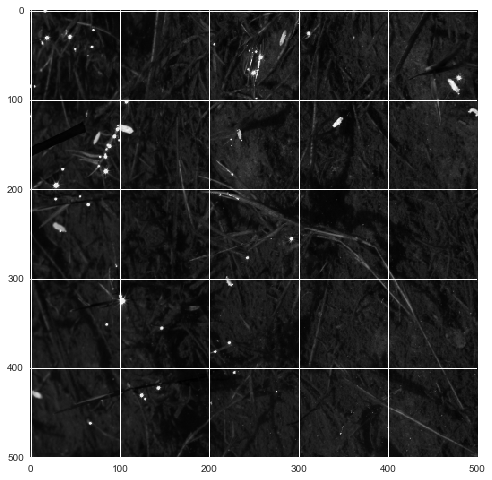

In [8]:
plt.imshow(natural_stimuli[0])

# Load photodiode

In [48]:
first_bin_file = data_dir + '150702a.bin'
header   = binary.readbinhdr(first_bin_file)
raw_data = binary.readbin(first_bin_file, chanlist=[0])

In [49]:
white_frames = np.loadtxt(data_dir + 'photodiode_white_frame_timestamps.txt')

In [50]:
white_frames[200:300]

array([  2.00640000e+00,   2.01640000e+00,   2.02650000e+00,
         2.03650000e+00,   2.04640000e+00,   2.05650000e+00,
         2.06650000e+00,   2.07650000e+00,   2.08640000e+00,
         2.09650000e+00,   2.10650000e+00,   2.11660000e+00,
         2.12660000e+00,   2.13650000e+00,   2.14650000e+00,
         2.15640000e+00,   2.16670000e+00,   2.17650000e+00,
         2.18660000e+00,   2.19650000e+00,   2.20680000e+00,
         2.21660000e+00,   2.22680000e+00,   2.23660000e+00,
         2.24660000e+00,   2.25660000e+00,   2.26660000e+00,
         2.27670000e+00,   2.28660000e+00,   2.29660000e+00,
         2.30670000e+00,   2.31680000e+00,   2.32670000e+00,
         2.33660000e+00,   2.34670000e+00,   2.35660000e+00,
         2.36680000e+00,   2.37680000e+00,   2.38670000e+00,
         2.39670000e+00,   2.40660000e+00,   2.41690000e+00,
         2.42660000e+00,   2.43680000e+00,   2.44670000e+00,
         2.45670000e+00,   2.46670000e+00,   2.47670000e+00,
         2.48670000e+00,

In [51]:
non_trivial_inds = np.diff(white_frames) > 1
non_trivial_inds = np.insert(non_trivial_inds, 0, 0)
white_frames[non_trivial_inds][0]

3.7776000000000001

First 4 trials were low/high/low/high contrast spatiotemporal white noise, each of 22.5 min long

In [52]:
white_frames[non_trivial_inds][:5]

array([  3.77760000e+00,   1.35391250e+03,   2.70404750e+03,
         4.05418270e+03,   5.40738980e+03])

In [53]:
np.diff(white_frames[non_trivial_inds][:5])

array([ 1350.1349,  1350.135 ,  1350.1352,  1353.2071])

In [54]:
1350.135/60.

22.50225

In [55]:
natural_scenes_start = white_frames[non_trivial_inds][5]

In [56]:
natural_scenes_start/60.

90.140176666666676

In [57]:
(f['expt5/timestamps'][-1]/60., np.mean(np.diff(f['expt5/timestamps'])))

(91.807425000000507, 0.020414352263630819)

Keep spikes that happen after the last natural scenes frame, as long as it is within the length of the retinal kernel

In [58]:
length_of_retinal_kernel = 0.4
frame_duration = np.mean(np.diff(f['expt5/timestamps']))
natural_scenes_end = natural_scenes_start + f['expt5/timestamps'][-1] + length_of_retinal_kernel

In [59]:
(natural_scenes_end - natural_scenes_start)/60.

91.814091666667153

# Load spiking data

In [60]:
fs = sorted(os.listdir(data_dir))
fs = [cell for cell in fs if cell.endswith(".txt")]

cells = []
for cell in fs:
    text_file = open(data_dir + cell, "r")
    spikes = text_file.read().split('\n')
    cells.append([float(spike) - natural_scenes_start for spike in spikes \
                  if (not (not spike)) and float(spike) - natural_scenes_start > 0 \
                  and float(spike) - natural_scenes_end <= 0])
    
    text_file.close()

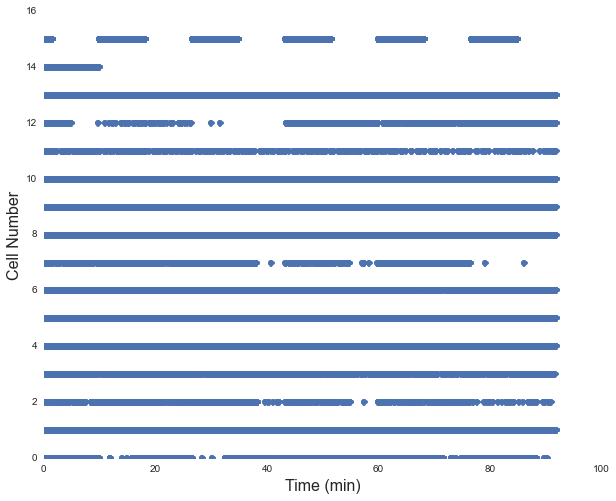

In [61]:
num_cells = len(cells)
all_spiking = np.hstack([ np.vstack((np.array(cell), np.ones(len(cell))*idx)) for idx, cell in enumerate(cells) ]).T
all_spiking.shape

plt.plot(all_spiking[:,0]/(60.), all_spiking[:,1], 'o')
plt.xlabel('Time (min)', fontsize=16)
plt.ylabel('Cell Number', fontsize=16)

In [64]:
sta, get_sta = pyret.filtertools.getsta(f['expt5/timestamps'], natural_stimuli[:1000], cells[0], 40)

ValueError: operands could not be broadcast together with shapes (500000,40) (500000,22) (500000,40) 

In [65]:
bspk, tax = pyret.spiketools.binspikes(cells[0], time=f['expt5/timestamps'])

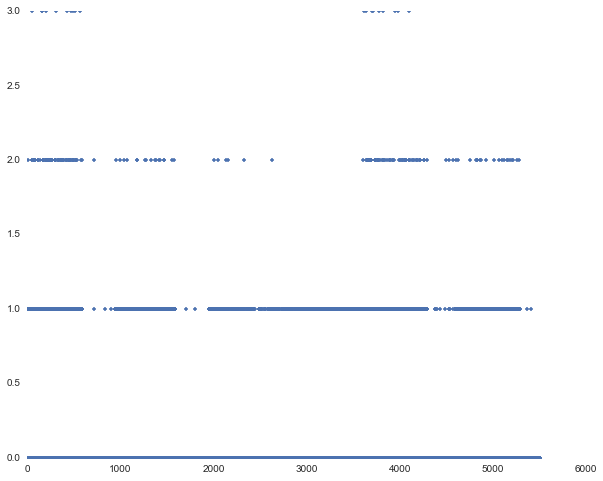

In [66]:
plt.plot(tax, bspk, '.')

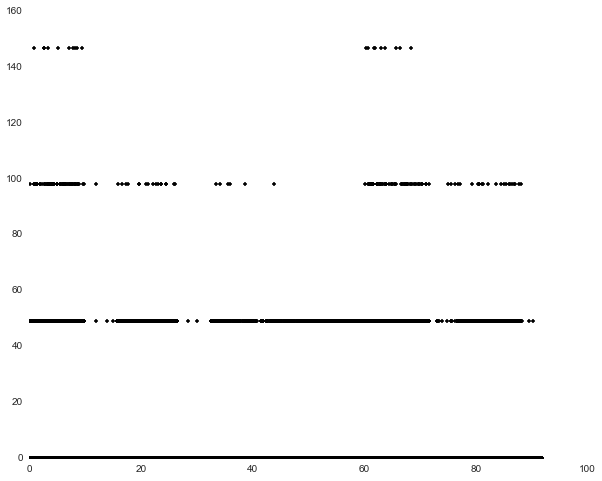

In [67]:
plt.plot(tax/60., bspk/np.mean(np.diff(f['expt5/timestamps'])),'k.')

In [68]:
sum(bspk > 1)

203

In [69]:
len(bspk)

269832

In [70]:
len(f['expt5/timestamps'])

269833

In [71]:
blah = natural_stimuli[1:4]

In [72]:
blah.shape

(3, 500, 500)

In [73]:
natural_stimuli[:4].shape

(4, 500, 500)

In [74]:
natural_stimuli.shape

(269833, 500, 500)

In [75]:
natural_stimuli.ndims

500

In [76]:
natural_stimuli[:100].shape

(100, 500, 500)

In [77]:
np.max(np.diff(f['expt5/timestamps']))

0.050099999993108213

In [78]:
np.min(np.diff(f['expt5/timestamps']))

0.019999999960418791

# Bin spikes at 10 ms resolution

In [79]:
bspk, tax = pyret.spiketools.binspikes(np.array(cells[0]), binsize=0.01)

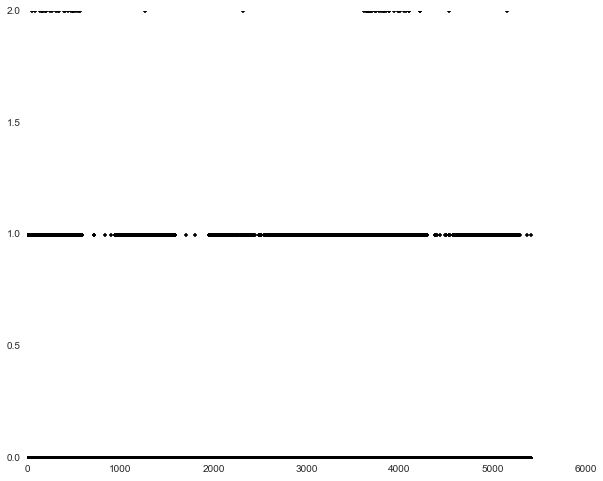

In [80]:
plt.plot(tax, bspk, 'k.')

In [81]:
sum(bspk > 1)

59

In [82]:
tax[:5]

array([ 0.005,  0.015,  0.025,  0.035,  0.045])

In [83]:
natural_stimuli.shape

(269833, 500, 500)

In [84]:
def returnTuple(*args):
    return tuple(args)

In [85]:
def interpnd(original_time, original_values, new_time, filename, filepath=None):
    '''Take a n-dimensional signal across time and return
    the n-dimensional signal with nearest interpolation to 
    the new time bins.
    
    Assumes original_values.shape[0] = original_time.shape[0]
    
    Writes output to file.
    '''
    large_number = 10 # needs to be larger than largest t - original-time
    duration = np.max(new_time)
    new_values_shape = returnTuple(new_time.shape[0], *original_values.shape[1:])
    if filepath:
        fname = filepath + filename
    else:
        fname = filename
    new_file = h5py.File(fname, "w")
    new_values = new_file.create_dataset("stimulus", new_values_shape, dtype='f')
    for idt,t in enumerate(new_time):
        if np.bitwise_and((t % (60*10)) >= 0.0, (t % (60*10)) <= 0.01):
            print '%d minutes / %f minutes' %(t/60., duration/60.)
        time_til_frame = t - original_time
        which_value = np.argmin(np.where(time_til_frame > 0, time_til_frame, large_number))
        new_values[idt] = original_values[which_value]
    new_file.close()
    

In [86]:
time_til_frame = tax[100] - f['expt5/timestamps']
np.argmin(np.where(time_til_frame > 0, time_til_frame, 10))

49

In [87]:
(tax[100], f['expt5/timestamps'][49])

(1.0049999999999999, 0.98070000001462176)

# Write new stimulus file aligned with binned spikes

In [88]:
data_dir

'/Users/lmcintosh/Documents/Stanford/00 Baccus Lab/Data 2015_07_02/'

In [89]:
interpnd(f['expt5/timestamps'][:], f['expt5/stim'], tax, 'natural_scenes_stimulus_norepeats_v8.h5', data_dir)

0 minutes / 90.199917 minutes
10 minutes / 90.199917 minutes
20 minutes / 90.199917 minutes
30 minutes / 90.199917 minutes
40 minutes / 90.199917 minutes
50 minutes / 90.199917 minutes
60 minutes / 90.199917 minutes
70 minutes / 90.199917 minutes
80 minutes / 90.199917 minutes
90 minutes / 90.199917 minutes


# Test new file

In [90]:
data_dir = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Data 2015_07_02/')
new_stim_file = data_dir + 'natural_scenes_stimulus_norepeats_v8.h5'
g = h5py.File(new_stim_file)

In [91]:
g.keys()

[u'stimulus']

In [93]:
g['stimulus'].shape

(541200, 3)

In [94]:
bspk.shape

(541200,)

In [101]:
g['stimulus']

array([  15.,  503.,  961.], dtype=float32)

## Final file should have three datasets, 'spikes', 'images', and 'stimulus'. All should be integer arrays.

## To save space, save images as uint8. This is also the resolution of the monitor.

In [29]:
def to_uint8(x):
    '''Converts an ndarray to uint8 datatype by first scaling to [0,255] and then calling
    .astype('uint8'). Calling .astype('uint8') before rescaling would change all numbers to 
    modulo 255. I.e. 256 would become 0.'''
    xmin = np.min(x)
    xmax = np.max(x)
    xscaled = 255 * (x - xmin) / (xmax - xmin)
    return xscaled.astype('uint8')

In [234]:
all_binned_spikes = []
cell_idx = []
for c in range(num_cells):
    bspk, tax = pyret.spiketools.binspikes(np.array(cells[c]), binsize=0.01)
    bspk = bspk.astype('int')
    if c == 0:
        max_duration = len(bspk)
        new_time = tax
    # last two cells are crap
    if len(bspk) >= max_duration:
        all_binned_spikes.append(np.expand_dims(bspk[:max_duration], 1))
        cell_idx.append(c) # cells 7, 15, 16 are skipped
all_spikes = np.hstack(all_binned_spikes)

In [235]:
cell_idx

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13]

In [236]:
original_time = f['expt5/timestamps'][:]
original_values = f['expt5/stim'][:].astype('int')
original_values[:,0] -= 1 # convert from Matlab to Python indexing
filename = 'natural_scenes_stimulus_compressed_v2.h5'
filepath = data_dir

# Stimulus dataset
large_number = 10 # needs to be larger than largest t - original-time
duration = np.max(new_time)
new_values_shape = returnTuple(new_time.shape[0], *original_values.shape[1:])
if filepath:
    fname = filepath + filename
else:
    fname = filename
new_file = h5py.File(fname, "w")
new_values = new_file.create_dataset("stimulus", new_values_shape, dtype='i')
for idt,t in enumerate(new_time):
    if np.bitwise_and((t % (60*10)) >= 0.0, (t % (60*10)) <= 0.01):
        print '%d minutes / %f minutes' %(t/60., duration/60.)
    time_til_frame = t - original_time
    which_value = np.argmin(np.where(time_til_frame > 0, time_til_frame, large_number))
    new_values[idt] = original_values[which_value]

# Spikes dataset
new_spikes = new_file.create_dataset("spikes", data=all_spikes)

# Images dataset
new_images = new_file.create_dataset("images", data=f['images'])

new_file.close()

0 minutes / 90.199917 minutes
10 minutes / 90.199917 minutes
20 minutes / 90.199917 minutes
30 minutes / 90.199917 minutes
40 minutes / 90.199917 minutes
50 minutes / 90.199917 minutes
60 minutes / 90.199917 minutes
70 minutes / 90.199917 minutes
80 minutes / 90.199917 minutes
90 minutes / 90.199917 minutes


In [239]:
all_spikes.shape

(541200, 13)

# Test full file

In [240]:
data_dir = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Data 2015_07_02/')
new_stim_file = data_dir + 'natural_scenes_stimulus_compressed.h5'
h = h5py.File(new_stim_file)

In [241]:
h.keys()

[u'images', u'spikes', u'stimulus']

In [242]:
h['images'].shape

(25, 1519, 1007)

In [243]:
h['spikes'].shape

(541200, 13)

In [244]:
h['stimulus'].shape

(541200, 3)

In [245]:
h['stimulus'][0]

array([ 14, 507, 963], dtype=int32)

In [246]:
np.min(h['stimulus'][:,0])

0

In [247]:
f['images'][0]

array([[ 210.3802706 ,  202.78896091,  209.37985054, ...,  209.01285382,
         236.38711222,  287.17474003],
       [ 168.95070458,  167.72639132,  196.80981562, ...,  283.89300379,
         286.45807854,  325.14921863],
       [ 164.00744402,  144.82802848,  160.32846339, ...,  312.29210523,
         359.72470327,  446.94218557],
       ..., 
       [ 180.91762581,  190.33437088,  133.53108289, ...,  340.50378148,
         486.11722257,  360.37391896],
       [ 215.81056849,  153.57321072,  130.33209541, ...,  466.16587591,
         420.06027598,  308.82271819],
       [ 156.31022895,  155.98418714,  156.49888309, ...,  304.3207512 ,
         293.91622933,  317.33696303]])

In [248]:
h['images'][0]

array([[ 210.3802706 ,  202.78896091,  209.37985054, ...,  209.01285382,
         236.38711222,  287.17474003],
       [ 168.95070458,  167.72639132,  196.80981562, ...,  283.89300379,
         286.45807854,  325.14921863],
       [ 164.00744402,  144.82802848,  160.32846339, ...,  312.29210523,
         359.72470327,  446.94218557],
       ..., 
       [ 180.91762581,  190.33437088,  133.53108289, ...,  340.50378148,
         486.11722257,  360.37391896],
       [ 215.81056849,  153.57321072,  130.33209541, ...,  466.16587591,
         420.06027598,  308.82271819],
       [ 156.31022895,  155.98418714,  156.49888309, ...,  304.3207512 ,
         293.91622933,  317.33696303]])

In [250]:
h.close()

ValueError: Not a file id (Not a file id)

In [17]:
np.array([0,1,400,200, 255, 256.1, 2.99]).astype('uint8')

array([  0,   1, 144, 200, 255,   0,   2], dtype=uint8)